# Real or Not? NLP with Disaster Tweets

Kaggle Competiton Real or Not real? NLP with Disaster Tweets

Twitter has become an important communication channel in times of emergency. The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

But, it’s not always clear whether a person’s words are actually announcing a disaster The author explicitly uses the word “ABLAZE” but means it metaphorically. This is clear to a human right away, especially with the visual aid. But it’s less clear to a machine.

In this competition, you’re challenged to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. You’ll have access to a dataset of 10,000 tweets that were hand classified. If this is your first time working on an NLP problem, we've created a quick tutorial to get you up and running.

### https://towardsdatascience.com/real-or-not-nlp-with-disaster-tweets-eda-c8961b204c7a

In [3]:
import pandas as pd
import numpy as np
import sys
sys.path.append('../')




## Read and clean data

In [4]:
train_data = pd.read_csv('F:/nlp fastai/DisasterTweetsNLP1master/data/train.csv')
test_data  = pd.read_csv('F:/nlp fastai/DisasterTweetsNLP1master/data/test.csv')
sample_submission = pd.read_csv('F:/nlp fastai/DisasterTweetsNLP1master/data/sample_submission.csv')


In [7]:
import re
import string

# Function to remove url
def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

# Function to remove html text
def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'', text)

# Function to remove emoji
def remove_emoji(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

# Function to remove punctuation
def remove_punctuation(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

In [8]:
def clean_wrapper(text): 
    text = remove_url(text)
    text = remove_html(text)
    text = remove_emoji(text)
    text = remove_punctuation(text)
    return text

In [9]:
train_data['text'] = train_data['text'].apply(lambda x : clean_wrapper(x))
test_data['text'] = test_data['text'].apply(lambda x : clean_wrapper(x))

In [10]:
sent_data = train_data.text.values
labels_data = train_data.target.values
sent_submission = test_data.text.values

In [13]:
from sklearn.model_selection import train_test_split
sent_train, sent_test, labels_train, labels_test = train_test_split(sent_data, labels_data, test_size=0.2, random_state=42)

## Prepare data for NNs

In [11]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [14]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sent_data)

X_train = tokenizer.texts_to_sequences(sent_data)
# X_test = tokenizer.texts_to_sequences(sent_test)
X_submission = tokenizer.texts_to_sequences(sent_submission)

y_train = labels_data
# y_test = labels_test

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

print(sent_train[2])
print(X_train[2])


Tell BarackObama to rescind medals of honor given to US soldiers at the Massacre of Wounded Knee SIGN NOW amp RT 
[38, 1694, 1570, 4, 2086, 3, 651, 20, 120, 6744, 17, 1695, 40, 415, 242, 53, 2086, 3, 651, 1351, 20, 1063]


In [15]:
maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
# X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
X_submission = pad_sequences(X_submission, padding='post', maxlen=maxlen)

print(X_train[0, :])

[ 109 4493   20    1  826    5   18  241  123 1569 4494   69   38    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


## Keras model

In [16]:
from tensorflow.keras import Sequential, layers, regularizers

In [17]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

### Learn word embeddings 

In [18]:
embedding_dim = 100
drop_out_prob = 0.3

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(30, activation='relu'))
model.add(layers.Dropout(drop_out_prob))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dropout(drop_out_prob))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          1810500   
_________________________________________________________________
global_max_pooling1d (Global (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 30)                3030      
_________________________________________________________________
dropout (Dropout)            (None, 30)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                310       
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1

Train on 6090 samples, validate on 1523 samples
Epoch 1/20
6090/6090 [==============================] - 5s 850us/sample - loss: 0.6789 - accuracy: 0.5683 - val_loss: 0.6767 - val_accuracy: 0.5345
Epoch 2/20
6090/6090 [==============================] - 3s 560us/sample - loss: 0.6235 - accuracy: 0.6327 - val_loss: 0.6211 - val_accuracy: 0.6717
Epoch 3/20
6090/6090 [==============================] - 3s 521us/sample - loss: 0.5212 - accuracy: 0.7816 - val_loss: 0.5601 - val_accuracy: 0.7663
Epoch 4/20
6090/6090 [==============================] - 3s 545us/sample - loss: 0.3832 - accuracy: 0.8690 - val_loss: 0.4823 - val_accuracy: 0.7754
Epoch 5/20
6090/6090 [==============================] - 3s 543us/sample - loss: 0.2342 - accuracy: 0.9259 - val_loss: 0.4911 - val_accuracy: 0.7682
Epoch 6/20
6090/6090 [==============================] - 3s 548us/sample - loss: 0.1575 - accuracy: 0.9525 - val_loss: 0.5416 - val_accuracy: 0.7584
Epoch 7/20
6090/6090 [==============================] - 3s 544us

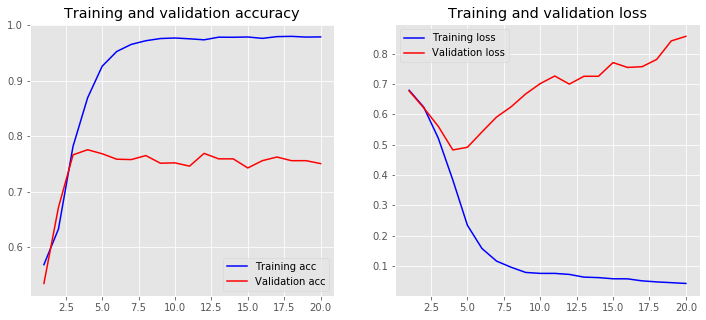

In [19]:
history = model.fit(X_train, y_train,
                    epochs=20,
                    verbose=1,
                    validation_split=0.2,
                    batch_size=100)
plot_history(history)

### Use GloVe

In [27]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
#file = open(filename, encoding="utf8")
    with open(filepath, encoding="utf8") as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [28]:
#downloaded from http://nlp.stanford.edu/data/glove.twitter.27B.zip
embedding_dim = 50
embedding_matrix = create_embedding_matrix(
    'F:/nlp fastai/DisasterTweetsNLP1master/glove.twitter.27B.50d.txt',
    tokenizer.word_index, embedding_dim)

drop_out_prob = 0.5

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim,
                           weights = [embedding_matrix],
                           input_length=maxlen, 
                           trainable=False))
# model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalAveragePooling1D())
model.add(layers.Dense(64, activation='relu',
                kernel_regularizer=regularizers.l2(0.01),
                activity_regularizer=regularizers.l1(0.01)))
model.add(layers.Dropout(drop_out_prob))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', learning_rate=0.001,
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 50)           905250    
_________________________________________________________________
global_average_pooling1d (Gl (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                3264      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 908,579
Trainable params: 3,329
Non-trainable params: 905,250
_________________________________________________________________


Train on 6851 samples, validate on 762 samples
Epoch 1/300
6851/6851 [==============================] - 2s 227us/sample - loss: 1.2470 - accuracy: 0.4840 - val_loss: 1.2151 - val_accuracy: 0.5276
Epoch 2/300
6851/6851 [==============================] - 0s 25us/sample - loss: 1.1923 - accuracy: 0.5468 - val_loss: 1.1644 - val_accuracy: 0.5341
Epoch 3/300
6851/6851 [==============================] - 0s 28us/sample - loss: 1.1424 - accuracy: 0.5704 - val_loss: 1.1179 - val_accuracy: 0.5341
Epoch 4/300
6851/6851 [==============================] - 0s 29us/sample - loss: 1.0963 - accuracy: 0.5771 - val_loss: 1.0755 - val_accuracy: 0.5341
Epoch 5/300
6851/6851 [==============================] - 0s 30us/sample - loss: 1.0550 - accuracy: 0.5798 - val_loss: 1.0370 - val_accuracy: 0.5341
Epoch 6/300
6851/6851 [==============================] - 0s 30us/sample - loss: 1.0182 - accuracy: 0.5785 - val_loss: 1.0022 - val_accuracy: 0.5341
Epoch 7/300
6851/6851 [==============================] - 0s 29us

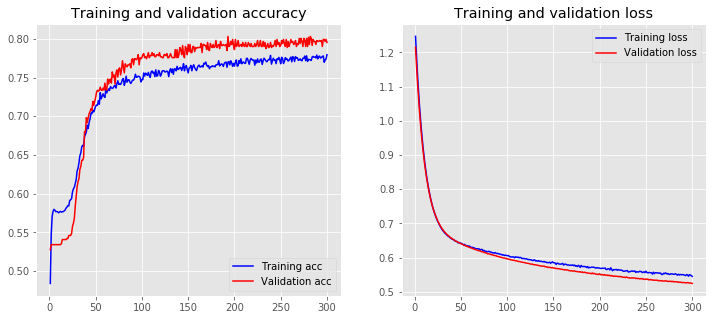

In [29]:
history = model.fit(X_train, y_train,
                    epochs=300,
                    verbose=1,
                    validation_split=0.1,
                    batch_size=1000, use_multiprocessing=True)
plot_history(history)

## Bert

## References
### https://web.stanford.edu/class/cs224n/reports/custom/15785631.pdf
### https://arxiv.org/pdf/1801.06146.pdf


What is BERT? 

In 2019 a model ruled over the entire NLP dimension and that is bert. Bert is not the solution to very NLP problem, but yes it does gives you a upper hand when it comes down to accuracy.
To understand bert you need to understand certain basic terms sunch as bidirectional encoder, transformer, look-ahead masking, transformer, and attention making(both multihead and self) in the world of NLP. For better understanding I would recommend you this article at Analytics Vidya(Link - https://www.analyticsvidhya.com/blog/2019/06/understanding-transformers-nlp-state-of-the-art-models/)

In [50]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.callbacks import ModelCheckpoint

In [32]:
%%time
module_url = 'https://tfhub.dev/google/universal-sentence-encoder-large/4'
embed = hub.KerasLayer(module_url, trainable=False, name='USE_embedding')

Wall time: 3min 6s


In [33]:
def build_model(embed):
    model = Sequential([
        layers.Input(shape=[], dtype=tf.string),
        embed,
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer = "adam", lr=0.0005, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [34]:
model = build_model(embed)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
USE_embedding (KerasLayer)   {'outputs': (None, 512)}  147354880 
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               32896     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)              

In [35]:
checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', save_best_only=True)

history = model.fit(
    sent_data, labels_data,
    validation_split=0.2,
    epochs=20,
    callbacks=[checkpoint],
    batch_size=32
)

Train on 6090 samples, validate on 1523 samples
Epoch 1/20
6090/6090 [==============================] - 303s 50ms/sample - loss: 0.5752 - accuracy: 0.7502 - val_loss: 0.6195 - val_accuracy: 0.5706
Epoch 2/20
6090/6090 [==============================] - 235s 39ms/sample - loss: 0.4603 - accuracy: 0.8002 - val_loss: 0.4858 - val_accuracy: 0.7938
Epoch 3/20
6090/6090 [==============================] - 240s 39ms/sample - loss: 0.4088 - accuracy: 0.8220 - val_loss: 0.3908 - val_accuracy: 0.8391
Epoch 4/20
6090/6090 [==============================] - 233s 38ms/sample - loss: 0.3817 - accuracy: 0.8355 - val_loss: 0.3900 - val_accuracy: 0.8345
Epoch 5/20
6090/6090 [==============================] - 231s 38ms/sample - loss: 0.3629 - accuracy: 0.8458 - val_loss: 0.3982 - val_accuracy: 0.8326
Epoch 6/20
6090/6090 [==============================] - 240s 39ms/sample - loss: 0.3381 - accuracy: 0.8576 - val_loss: 0.3988 - val_accuracy: 0.8385
Epoch 7/20
6090/6090 [==============================] - 22

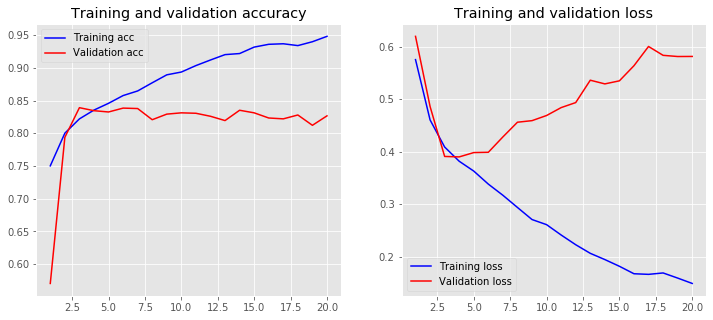

In [36]:
plot_history(history)

In [37]:
model.load_weights('model.h5')
test_pred = model.predict(sent_submission)

test_data['target'] = test_pred.round().astype(int)
submission = test_data[['id', 'target']]
submission.to_csv('F:/nlp fastai/DisasterTweetsNLP1master/submission1.csv', index=False)

In [49]:
y_submission = model.predict(sent_submission)
test_data['target'] = (y_submission > 0.5).astype(int)
submission = test_data[['id', 'target']]
submission.to_csv('F:/nlp fastai/DisasterTweetsNLP1master/submission1.csv', index=False)

In [39]:
submission.target.value_counts()

0    2118
1    1145
Name: target, dtype: int64

In [40]:
sample_submission

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0
...,...,...
3258,10861,0
3259,10865,0
3260,10868,0
3261,10874,0


In [42]:
submission

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1
